In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import allantools as at
from scipy.stats import norm

# Section 1 - Define functions to generate synthetic data

In [95]:
save_dir = '/eos/user/e/elsweene/SWAN_projects/Filtered_data_sets/'

In [96]:
save_dir1 = '/eos/user/e/elsweene/SWAN_projects/'

In [97]:
## Load in CSF data 

Most_recent_data = pd.read_csv(save_dir1 + "recent_data_30_days_04_08.csv")
filter2 = pd.read_csv(save_dir +"CSF_data_frame_filter2.csv",index_col=0)
CSF_frame = pd.read_csv(save_dir +"CSF_data_frame_unfiltered.csv",index_col=0)

In [98]:
Most_recent_data['timestamp']

0      60138.625000
1      60138.666667
2      60138.708333
3      60138.750000
4      60138.791667
           ...     
530    60160.708333
531    60160.750000
532    60160.791667
533    60160.833333
534    60160.875000
Name: timestamp, Length: 535, dtype: float64

In [99]:
## Filter frame data because tocsv doesn't save emptys

CSF_filter_frame =(CSF_frame[abs(CSF_frame['f0'])<.5e-12])

-6.036791936445496e-17 3.624650117771767e-12


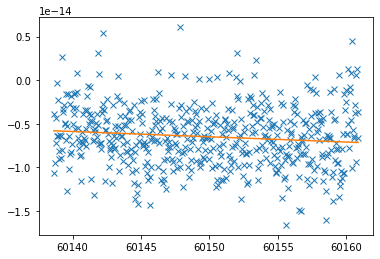

In [145]:
## Get rolling mean and fit line for linear drift

rolling_mean = np.array(Most_recent_data['f0'].rolling(window=24).mean().dropna())
shifted = np.array(Most_recent_data['f0'][:512]-rolling_mean)
m_rm, b_rm = np.polyfit(Most_recent_data['timestamp'][:512],-1*rolling_mean, 1)
print(m_rm,b_rm)

plt.plot(Most_recent_data['timestamp'],-1*Most_recent_data['f0'],'x')
plt.plot(Most_recent_data['timestamp'],m_rm*Most_recent_data['timestamp']+b_rm)

In [130]:
## Function of fitted linear drift line 

def mean_line(x,m,b):
    
    line = m*x+b
    return line

In [131]:
## Function for linear drift distribution

def linear_drift_dist(rm_range,linear_drift):

    list_differences = []

    for i in rm_range:

        x1 = linear_drift[i]
        x2 = linear_drift[i+1]

        diff = x1 - x2

        list_differences.append(diff)
    
    mu1, std1 = norm.fit(list_differences)
    
    return mu1,std1

In [132]:
## Function to add random walk drift to generated mean line data

def generate_random_walk(start_mean,start_sd,time_period,scalar,slope,constant):

    RW_Noise_data = []
    M= start_mean
    S = start_sd

    for i in time_period:
        #print(M)
        y_gen1 = mean_line(i,slope,constant)
        draw_noise = norm.rvs(loc=M,scale=(scalar*S),size=1)

        new_freq = y_gen1 + draw_noise

        RW_Noise_data.append(new_freq)

        M = draw_noise
        #print(M)
        
    Rand_walk_array = np.array(RW_Noise_data)
        
    return Rand_walk_array

In [133]:
## Define function to add white noise to generated data

def add_white_noise(index_array,RW_array,no_drift_array):    
    
    generated_freq = []
    mu, std = norm.fit(no_drift_array)

    for i in index_array:

        y_gen = RW_array[i]
        add_noise = norm.rvs(y_gen,scale= std,size=1)
        a = add_noise[0]

        generated_freq.append(a)
        
    return generated_freq

In [121]:
## Function to plot synthetic data beside original data

def plot_gen_data(time_frame,gen_freq):
    
    plot_original_data = plt.scatter(Most_recent_data['timestamp'][:512],-1*Most_recent_data['f0'][:512],color='g',label='CSF most recent data')
    plot_fit_line = plt.plot(Most_recent_data['timestamp'][:512], m_rm*np.array(Most_recent_data['timestamp'][:512]) + b_rm,'r')
    
    plot_linear_drift = plt.plot(Most_recent_data['timestamp'][:512],-1*rolling_mean,'o',color='c')
    plot_generated_data = plt.plot(time_frame,gen_freq,'o',color='g')
    
    return plot_original_data, plot_fit_line,plot_linear_drift,plot_generated_data
#    return plot_linear_drift,plot_generated_data

In [122]:
## Function to save synthetic data to file 

def save_to(synthetic_data,time_frame,original_data):
    
    generated_data_freq = np.concatenate((original_data,synthetic_data))
    generated_data_time = np.concatenate((Most_recent_data['timestamp'][:512],time_frame))
    
    gen_data = {'Time': generated_data_time,
        'Generated FF': generated_data_freq }
  
    df_generated_CSF = pd.DataFrame(gen_data, columns=['Time', 'Generated FF'])
    
    return df_generated_CSF

# Section 2 - Generate regular set synthetic data

In [134]:
mean,stan_dev = linear_drift_dist(np.arange(0,511,1),-1*rolling_mean)
mean,stan_dev

(-4.1128009936794366e-18, 1.8948080731447855e-16)

In [135]:
Ran_Walk_array = generate_random_walk(mean,stan_dev,np.arange(60160,60525,1/24),1,m_rm,b_rm)

In [136]:
len(Ran_Walk_array)

8760

In [137]:
Generated_data = add_white_noise(np.arange(0,8760,1),Ran_Walk_array,shifted)
#Generated_data

(<matplotlib.collections.PathCollection at 0x7f779f87a3a0>,
 [<matplotlib.lines.Line2D at 0x7f779f87acd0>])

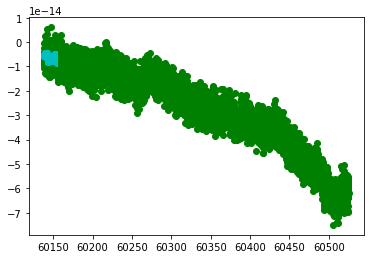

In [140]:
plot_gen_data(np.arange(60160,60525,1/24),Generated_data)

#plt.ylim(-3e-13,0.2e-13)

In [142]:
synthetic_data_recent_regular = save_to(Generated_data,np.arange(60160,60525,1/24),-1*Most_recent_data['f0'][:512])

In [143]:
save_dir2 = '/eos/user/e/elsweene/SWAN_projects/Synthetic_Data/'

In [144]:
synthetic_data_recent_regular.to_csv(save_dir2 + "generated_data_regular_updated_04_08.csv", index=True)

In [22]:
#plt.plot(synthetic_data_recent_regular['Time'],synthetic_data_recent_regular['Generated FF'],'x')

# Section 3 - Synthetic Data with no Linear Drift

In [23]:
## Remove linear drift

linear_drift_array = -1*Most_recent_data['f0'][:331]
fitted_lin_drift = mean_line(Most_recent_data['timestamp'][:331],m_rm,b_rm)

no_linear_drift = linear_drift_array-fitted_lin_drift

In [24]:
## Fit line to data w linear drift removed

m_no_LD, b_no_LD = np.polyfit(Most_recent_data['timestamp'][:331],no_linear_drift,1)

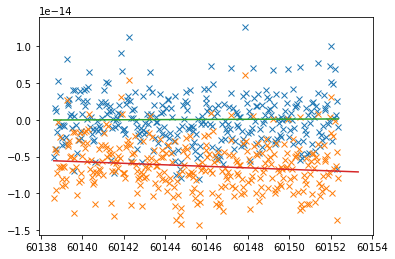

In [54]:
plt.plot(Most_recent_data['timestamp'][:331],no_linear_drift,'x')
plt.plot(Most_recent_data['timestamp'][:331],linear_drift_array,'x')

m_no_LD, b_no_LD = np.polyfit(Most_recent_data['timestamp'][:331],no_linear_drift,1)
#print(m_no_LD)

plt.plot(Most_recent_data['timestamp'][:331],m_no_LD*Most_recent_data['timestamp'][:331]+b_no_LD)
plt.plot(Most_recent_data['timestamp'],m_rm*Most_recent_data['timestamp']+b_rm)

In [26]:
mean_no_LD,stan_dev_no_LD = linear_drift_dist(np.arange(0,330,1),no_linear_drift)

In [27]:
mean_no_LD

-1.250297647891277e-17

In [31]:
Ran_Walk_array_no_LD = generate_random_walk(mean,stan_dev,np.arange(60152,60501,1/24),1,m_no_LD,b_no_LD)

In [32]:
Generated_data_no_LD = add_white_noise(np.arange(0,8376,1),Ran_Walk_array_no_LD,shifted)

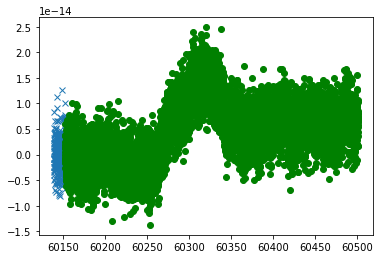

In [33]:
## Plot generated data

plt.plot(Most_recent_data['timestamp'][:331], m_no_LD*np.array(Most_recent_data['timestamp'][:331]) + b_no_LD,'r')
    
plt.plot(Most_recent_data['timestamp'][:331],no_linear_drift,'x')
plt.plot(np.arange(60152,60501,1/24),Generated_data_no_LD,'o',color='g')

In [34]:
synthetic_data_no_LD_up_to_date = save_to(Generated_data_no_LD,np.arange(60152,60501,1/24),no_linear_drift)

In [35]:
synthetic_data_no_LD_up_to_date.to_csv(save_dir2 + "generated_data_no_linear_drift_up_to_date_04_08.csv", index=True)

# Section 4 - Synthetic Data w no linear drift and 5x Random Walk

In [45]:
Ran_Walk_array_no_LD_5RW = generate_random_walk(mean,stan_dev,np.arange(60152,60501,1/24),5,m_no_LD,b_no_LD)

In [46]:
Generated_data_no_LD_5RW = add_white_noise(np.arange(0,8376,1),Ran_Walk_array_no_LD_5RW,shifted)

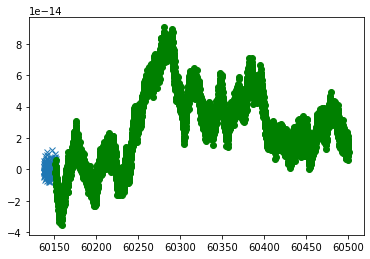

In [47]:
## Plot Generated Data

plt.plot(Most_recent_data['timestamp'], m_no_LD*np.array(Most_recent_data['timestamp']) + b_no_LD,'r')
    
plt.plot(Most_recent_data['timestamp'][:331],no_linear_drift,'x')
plt.plot(np.arange(60152,60501,1/24),Generated_data_no_LD_5RW,'o',color='g')

In [48]:
synthetic_data_no_LD_5RW_updated = save_to(Generated_data_no_LD_5RW,np.arange(60152,60501,1/24),no_linear_drift)

In [49]:
synthetic_data_no_LD_5RW_updated.to_csv(save_dir2 + "generated_data_no_linear_drift_5x_Random_Walk_updated.csv", index=True)

# Section 5 - Synthetic data with 5x Linear Drift

In [50]:
linear_drift_array = -1*Most_recent_data['f0'][:331]
fitted_5x_lin_drift = mean_line(Most_recent_data['timestamp'][:331],4*m_rm,((-4*m_rm*Most_recent_data['timestamp'][0])))

In [51]:
linear_drift_x5 = linear_drift_array+fitted_5x_lin_drift

In [52]:
m_5x_LD, b_5x_LD = np.polyfit(Most_recent_data['timestamp'][:331],linear_drift_x5,1)

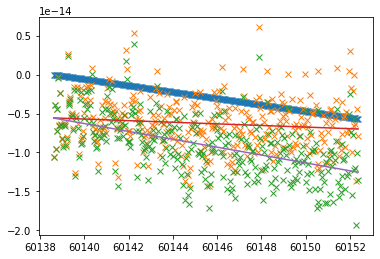

In [53]:
plt.plot(Most_recent_data['timestamp'][:331],fitted_5x_lin_drift,'x')
plt.plot(Most_recent_data['timestamp'][:331],linear_drift_array,'x')
plt.plot(Most_recent_data['timestamp'][:331],linear_drift_x5,'x')

# m_no_LD, b_no_LD = np.polyfit(Truncated_Time_data['TimeStamp'][:875],no_linear_drift,1)
# #print(m_no_LD)

plt.plot(Most_recent_data['timestamp'][:331],m_rm*Most_recent_data['timestamp'][:331]+b_rm)
plt.plot(Most_recent_data['timestamp'][:331],m_5x_LD*Most_recent_data['timestamp'][:331]+b_5x_LD)

In [56]:
mean_5x,stan_dev_5x = linear_drift_dist(np.arange(0,330,1),linear_drift_x5)

In [57]:
Ran_Walk_array_5x_LD = generate_random_walk(mean,stan_dev,np.arange(60152,60501,1/24),1,m_5x_LD,b_5x_LD)

In [58]:
Generated_data_5x_LD = add_white_noise(np.arange(0,8376,1),Ran_Walk_array_5x_LD,shifted)

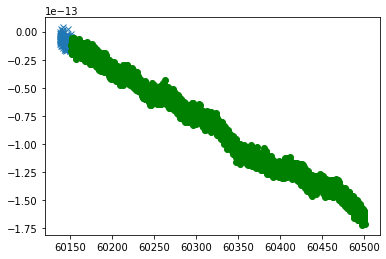

In [60]:
## Plot Generated Data

plt.plot(Most_recent_data['timestamp'], m_5x_LD*np.array(Most_recent_data['timestamp']) + b_5x_LD,'r')
    
plt.plot(Most_recent_data['timestamp'][:331],linear_drift_x5,'x')
plt.plot(np.arange(60152,60501,1/24),Generated_data_5x_LD,'o',color='g')

In [61]:
synthetic_data_5x_LD_updated = save_to(Generated_data_5x_LD,np.arange(60152,60501,1/24),linear_drift_x5)

In [62]:
synthetic_data_5x_LD_updated.to_csv(save_dir2 + "generated_data_5x_linear_drift_updated.csv", index=True)

# Section 6 - Synthetic data with 10x Linear Drift

In [63]:
linear_drift_array = -1*Most_recent_data['f0'][:331]
fitted_10x_lin_drift = mean_line(Most_recent_data['timestamp'][:331],9*m_rm,((-9*m_rm*Most_recent_data['timestamp'][:331][0])))

In [64]:
linear_drift_x10 = linear_drift_array+fitted_10x_lin_drift

In [65]:
m_10x_LD, b_10x_LD = np.polyfit(Most_recent_data['timestamp'][:331],linear_drift_x10,1)

In [66]:
print(m_10x_LD,b_10x_LD)

-1.0219791676706545e-15 6.145483198955885e-11


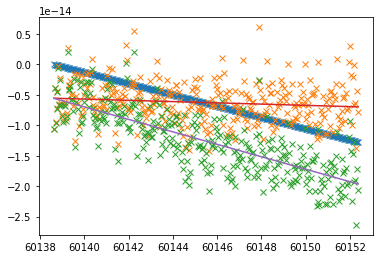

In [67]:
plt.plot(Most_recent_data['timestamp'][:331],fitted_10x_lin_drift,'x')
plt.plot(Most_recent_data['timestamp'][:331],linear_drift_array,'x')
plt.plot(Most_recent_data['timestamp'][:331],linear_drift_x10,'x')

# m_no_LD, b_no_LD = np.polyfit(Truncated_Time_data['TimeStamp'][:875],no_linear_drift,1)
# #print(m_no_LD)

plt.plot(Most_recent_data['timestamp'][:331],m_rm*Most_recent_data['timestamp'][:331]+b_rm)
plt.plot(Most_recent_data['timestamp'][:331],m_10x_LD*Most_recent_data['timestamp'][:331]+b_10x_LD)

In [68]:
mean_10x,stan_dev_10x = linear_drift_dist(np.arange(0,330,1),linear_drift_x10)

In [69]:
Ran_Walk_array_10x_LD = generate_random_walk(mean,stan_dev,np.arange(60152,60501,1/24),1,m_10x_LD,b_10x_LD)

In [70]:
Generated_data_10x_LD = add_white_noise(np.arange(0,8376,1),Ran_Walk_array_10x_LD,shifted)

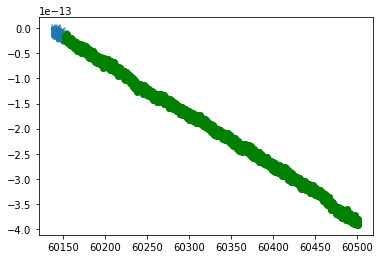

In [71]:
## Plot Generated Data

plt.plot(Most_recent_data['timestamp'], m_10x_LD*np.array(Most_recent_data['timestamp']) + b_10x_LD,'r')
    
plt.plot(Most_recent_data['timestamp'][:331],linear_drift_x10,'x')
plt.plot(np.arange(60152,60501,1/24),Generated_data_10x_LD,'o',color='g')

In [72]:
synthetic_data_10x_LD_updated = save_to(Generated_data_10x_LD,np.arange(60152,60501,1/24),linear_drift_x10)

In [73]:
synthetic_data_10x_LD_updated.to_csv(save_dir2 + "generated_data_10x_linear_drift_updated.csv", index=True)

# Section 7 - Synthetic data with 5x Linear Drift & 5x Random Walk

In [74]:
Ran_Walk_array_10x_LD_5x_RW = generate_random_walk(mean,stan_dev,np.arange(60152,60501,1/24),5,m_10x_LD,b_10x_LD)

In [75]:
Generated_data_10x_LD_5x_RW = add_white_noise(np.arange(0,8376,1),Ran_Walk_array_10x_LD_5x_RW,shifted)

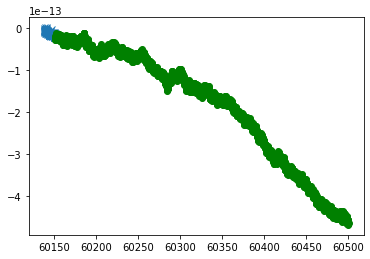

In [76]:
## Plot Generated Data

plt.plot(Most_recent_data['timestamp'], m_10x_LD*np.array(Most_recent_data['timestamp']) + b_10x_LD,'r')
    
plt.plot(Most_recent_data['timestamp'][:331],linear_drift_x10,'x')
plt.plot(np.arange(60152,60501,1/24),Generated_data_10x_LD_5x_RW,'o',color='g')

In [77]:
synthetic_data_10x_LD_5x_RW_updated = save_to(Generated_data_10x_LD_5x_RW,np.arange(60152,60501,1/24),linear_drift_x10)

In [78]:
synthetic_data_10x_LD_5x_RW_updated.to_csv(save_dir2 + "generated_data_10x_5x_RW_linear_drift_updated.csv", index=True)

# Section 8 - No LD 0.5 RW

In [79]:
Ran_Walk_array_no_LD_half_RW = generate_random_walk(mean,stan_dev,np.arange(60152,60501,1/24),0.5,m_no_LD,b_no_LD)

In [80]:
Generated_data_no_LD_half_RW = add_white_noise(np.arange(0,8376,1),Ran_Walk_array_no_LD_half_RW,shifted)

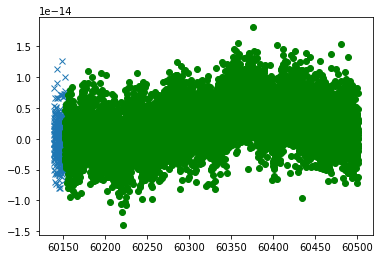

In [81]:
## Plot Generated Data

plt.plot(Most_recent_data['timestamp'], m_no_LD*np.array(Most_recent_data['timestamp']) + b_no_LD,'r')
    
plt.plot(Most_recent_data['timestamp'][:331],no_linear_drift,'x')
plt.plot(np.arange(60152,60501,1/24),Generated_data_no_LD_half_RW,'o',color='g')

In [82]:
synthetic_data_no_LD_half_RW_updated = save_to(Generated_data_no_LD_half_RW,np.arange(60152,60501,1/24),no_linear_drift)

In [83]:
synthetic_data_no_LD_half_RW_updated.to_csv(save_dir2 + "generated_data_no_linear_drift_half_Random_Walk_updated.csv", index=True)

# Section 9 - Original LD , 0.5 RW

In [84]:
Ran_Walk_array_half_rw = generate_random_walk(mean,stan_dev,np.arange(60152,60501,1/24),0.5,m_rm,b_rm)

In [85]:
Generated_data_half_rw = add_white_noise(np.arange(0,8376,1),Ran_Walk_array_half_rw,shifted)

(<matplotlib.collections.PathCollection at 0x7f779fe29e50>,
 [<matplotlib.lines.Line2D at 0x7f779fe1c790>])

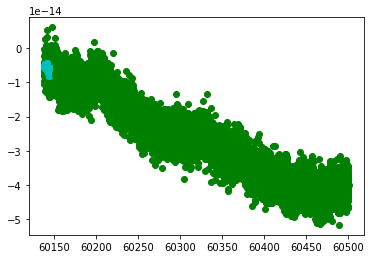

In [86]:
plot_gen_data(np.arange(60152,60501,1/24),Generated_data_half_rw)

In [87]:
synthetic_data_regular_w_half_rw_updated = save_to(Generated_data_half_rw,np.arange(60152,60501,1/24),-1*Most_recent_data['timestamp'][:331])

In [88]:
synthetic_data_regular_w_half_rw_updated.to_csv(save_dir2 + "generated_data_regular_w_half_rw_updated.csv", index=True)